In [4]:
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from shapely.geometry import Point
from sklearn.neighbors import BallTree
from sklearn.metrics import mean_squared_error
import xgboost as xgb

import warnings

# Suppress the FutureWarning related to is_categorical_dtype from TargetEncoder
warnings.filterwarnings("ignore", category=FutureWarning)

class MyTargetEncoder():
    def __init__(self, columns_to_target_encode, training_data):
        self.encoders = {}
        self.columns_to_target_encode = columns_to_target_encode
        for col in columns_to_target_encode:
            encoder = TargetEncoder()
            encoder.fit(training_data[col], training_data['monthly_rent'])
            self.encoders[col] = encoder
        
    def fit_data(self, encoded_data):
        for col, encoder in self.encoders.items():
            encoded_data[col] = encoder.transform(encoded_data[col])
        return encoded_data

def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))

def clean_data(data):
    cleaned_data = data
    # cleaned_data = cleaned_data.drop_duplicates(subset=None, keep='first', inplace=False)
    cleaned_data = cleaned_data.drop(columns=['furnished', 'elevation', 'town', 'block', 'street_name', 'planning_area'])
    cleaned_data['flat_type'] = cleaned_data['flat_type'].str.replace(r'(2|3|4|5)-room|(\d) room', r'\1\2', regex=True)
    cleaned_data['flat_type'] = cleaned_data['flat_type'].str.replace('executive', '6')
    cleaned_data['flat_type'] = cleaned_data['flat_type'].astype(int)
    cleaned_data['rent_approval_date'] = cleaned_data['rent_approval_date'].str[2:].str.replace('-', '', regex=False)
    cleaned_data['rent_approval_date'] = cleaned_data['rent_approval_date'].astype(int)
    
    return cleaned_data


def encode_data(train_org, training_cleaned, valid_cleaned, testing_cleaned):
    # First Target Encoding
    
    columns_to_target_encode = ['flat_model', 'subzone']
    myTargetEncoder = MyTargetEncoder(columns_to_target_encode, train_org)
    
    training_encoded = myTargetEncoder.fit_data(training_cleaned)
    valid_encoded = myTargetEncoder.fit_data(valid_cleaned)
    testing_encoded = myTargetEncoder.fit_data(testing_cleaned)
    
    # Now, One-Hot Encoding
    
    # Prepare Model
    myOneHotEncoder = OneHotEncoder(sparse=False)
    myOneHotEncoder.fit(training_encoded[['region']])
    
    # Fit on train data
    tr1 = myOneHotEncoder.transform(training_encoded[['region']])
    tr2 = pd.DataFrame(tr1, columns=myOneHotEncoder.get_feature_names_out(['region']))
    tr3 = pd.concat([training_encoded.reset_index(drop=True), tr2.reset_index(drop=True)], axis=1)

    training_encoded = tr3.drop(columns=["region"])
    
    # Fit on valid data
    va1 = myOneHotEncoder.transform(valid_encoded[['region']])
    va2 = pd.DataFrame(va1, columns=myOneHotEncoder.get_feature_names_out(['region']))
    va3 = pd.concat([valid_encoded.reset_index(drop=True), va2.reset_index(drop=True)], axis=1)

    valid_encoded = va3.drop(columns=["region"])
    
    # Fit on test data
    te1 = myOneHotEncoder.transform(testing_encoded[['region']])
    te2 = pd.DataFrame(te1, columns=myOneHotEncoder.get_feature_names_out(['region']))
    te3 = pd.concat([testing_encoded.reset_index(drop=True), te2.reset_index(drop=True)], axis=1)

    testing_encoded = te3.drop(columns=["region"])
    
    return training_encoded, valid_encoded, testing_encoded


def scale_data(training_encoded, validation_encoded, testing_encoded):
    scaler = StandardScaler()
    training_scaled = scaler.fit_transform(training_encoded)
    validation_scaled = scaler.fit_transform(validation_encoded)
    testing_scaled = scaler.fit_transform(testing_encoded)
    return training_scaled, validation_scaled, testing_scaled

def preprocess_data(train_org, training_data_raw, valid_data_raw, testing_data_raw):
    
    training_cleaned = clean_data(training_data_raw)
    valid_cleaned = clean_data(valid_data_raw)
    testing_cleaned = clean_data(testing_data_raw)
    
    training_encoded, valid_encoded, testing_encoded = encode_data(train_org, training_cleaned, valid_cleaned, testing_cleaned)

    return training_encoded, valid_encoded, testing_encoded

def add_aux_data_count_in_radius(training_data_raw, training_coords, col_name, aux_data_raw, radius):
    geom_list_aux = [Point(lon,lat) for lon,lat in zip(aux_data_raw["longitude"], aux_data_raw["latitude"])]
    gdf_aux = gpd.GeoDataFrame(aux_data_raw, geometry=geom_list_aux, crs="EPSG:4326")

    # this uses the right projection to get the distance in m scale
    gdf_aux.to_crs(epsg=3414, inplace=True)
    aux_coords = np.array(gdf_aux.geometry.apply(lambda point: (point.x, point.y)).tolist())

    aux_tree = BallTree(aux_coords, leaf_size=20)
    
    # Perform the query
    count_aux_within_radius = aux_tree.query_radius(training_coords, r=radius, count_only=True)
    training_data_raw[col_name] = count_aux_within_radius

    return training_data_raw

def add_aux_data_nearest_dist(training_data_raw, training_coords, col_name, aux_data_raw):
    geom_list_aux = [Point(lon,lat) for lon,lat in zip(aux_data_raw["longitude"], aux_data_raw["latitude"])]
    gdf_aux = gpd.GeoDataFrame(aux_data_raw, geometry=geom_list_aux, crs="EPSG:4326")

    # this uses the right projection to get the distance in m scale
    gdf_aux.to_crs(epsg=3414, inplace=True)
    aux_coords = np.array(gdf_aux.geometry.apply(lambda point: (point.x, point.y)).tolist())

    aux_tree = BallTree(aux_coords, leaf_size=20)

    aux_distances, _ = aux_tree.query(training_coords, k=1)  # k=1 for finding the nearest point
    training_data_raw[col_name] = aux_distances

    return training_data_raw

def add_aux_data(org_dataset):
    # Add auxiliary data
    df_schools = pd.read_csv('auxiliary-data/sg-primary-schools.csv')
    gep_schools = ["Anglo-Chinese School (Primary)", "Catholic High School (Primary)", "Henry Park Primary School",
              "Nan Hua Primary School", "Nanyang Primary School", "Raffles Girls' Primary School", "Rosyth School",
              "St. Hilda's Primary School", "Tao Nan School"]
    df_gep_schools = df_schools[df_schools["name"].isin(gep_schools)]
    df_malls = pd.read_csv('auxiliary-data/sg-shopping-malls.csv')
    df_mrts = pd.read_csv('auxiliary-data/sg-mrt-existing-stations.csv')

    # org_dataset is either raw training or raw test data
    geom_list = [Point(lon,lat) for lon,lat in zip(org_dataset["longitude"], org_dataset["latitude"])]
    gdf_data = gpd.GeoDataFrame(org_dataset, geometry=geom_list, crs="EPSG:4326")
    # this uses the right projection to get the distance in m scale
    gdf_data.to_crs(epsg=3414, inplace=True)
    coords = np.array(gdf_data.geometry.apply(lambda point: (point.x, point.y)).tolist())

    org_dataset = add_aux_data_count_in_radius(org_dataset, coords, 'pri_schs_within_6km', df_schools, 6000)
    org_dataset = add_aux_data_count_in_radius(org_dataset, coords, 'gep_schs_within_5km', df_gep_schools, 5000)
    org_dataset = add_aux_data_count_in_radius(org_dataset, coords, 'malls_within_3km', df_malls, 3000)
    org_dataset = add_aux_data_count_in_radius(org_dataset, coords, 'mrts_within_3km', df_mrts, 3000)

    org_dataset = add_aux_data_nearest_dist(org_dataset, coords, 'nearest_distance_to_gep', df_gep_schools)
    org_dataset = add_aux_data_nearest_dist(org_dataset, coords, 'nearest_distance_to_mall', df_malls)
    org_dataset = add_aux_data_nearest_dist(org_dataset, coords, 'nearest_distance_to_mrt', df_mrts)

    return org_dataset

def get_stock_data(average_monthly_data ,stock_name, year, month):
    return average_monthly_data.loc[(stock_name, year, month)]

def chunk(nameslist):
    for i in range(0, len(nameslist), 10):
        yield nameslist[i:i+10]

def add_stock_data(org_dataset):
    stockdata = pd.read_csv("auxiliary-data/sg-stock-prices.csv")

    stockdata['date'] = pd.to_datetime(stockdata['date'])
    stockdata['year'], stockdata['month'] = stockdata['date'].dt.year, stockdata['date'].dt.month
    average_monthly_data = stockdata.groupby(['name', 'year', 'month']).mean(numeric_only=True).reset_index()

    names = set(stockdata['name'])

    stockdata_pivot = average_monthly_data.pivot_table(index=['year', 'month'], columns='name', values='adjusted_close').reset_index()
    stockdata_pivot['year'] = stockdata_pivot['year'].astype(int)
    stockdata_pivot['month'] = stockdata_pivot['month'].astype(int)

    org_dataset[['year', 'month']] = org_dataset['rent_approval_date'].str.split('-', expand=True)
    org_dataset['year'] = org_dataset['year'].astype(int)
    org_dataset['month'] = org_dataset['month'].astype(int)

    merged = pd.merge(org_dataset, stockdata_pivot, on=['year', 'month'], how='left')

    # Use interpolation to fill NaN values for each stock column
    for stock in average_monthly_data['name'].unique():
        merged[stock] = merged[stock].interpolate(method='nearest').ffill().bfill()

    nameslist = list(names)
    # chunked = list(chunk(nameslist))
    merged['average_stock_value'] = merged[nameslist].mean(axis=1)
    merged = merged.drop(nameslist, axis=1)
    merged = merged.drop(['year', 'month'], axis=1)
    return merged

In [6]:
training_data_raw = pd.read_csv('train.csv')
testing_data_raw = pd.read_csv('test.csv')

training_data_raw = add_aux_data(training_data_raw)
testing_data_raw = add_aux_data(testing_data_raw)

training_data_raw = add_stock_data(training_data_raw)
testing_data_raw = add_stock_data(testing_data_raw)

train_X, train_y = training_data_raw.drop('monthly_rent', axis=1), training_data_raw[['monthly_rent']]

#### Try different n for Kfolds

In [10]:
n_range = range(3, 11)
avg_rmse = []

for n in n_range:
    kfold = KFold(n_splits=n, shuffle=True, random_state=42)
    scores = []

    for train_index, val_index in kfold.split(train_X):
        X_train, X_val = train_X.iloc[train_index], train_X.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
    
        X_train, X_val, test_data = preprocess_data(training_data_raw, X_train, 
            X_val, testing_data_raw)
        X_train, X_val, X_test = scale_data(X_train, X_val, test_data)
    
        xgb_model = xgb.XGBRegressor(
            n_estimators=1200, max_depth=5, eta=0.01, subsample=0.7, colsample_bytree=0.7,
            objective="reg:squarederror"
        )
    
        xgb_model.fit(X_train, y_train)
        y_val_pred = xgb_model.predict(X_val)
        
        scores.append(mean_squared_error(y_val, y_val_pred))

    mean_score = np.sqrt(np.mean(scores))
    avg_rmse.append(mean_score)

    print("Number of folds: ", n)
    print("Mean RMSE: ", mean_score)
    # display_scores(np.sqrt(scores))

print(avg_rmse)

Number of folds:  3
Mean RMSE:  503.23064949100717
Number of folds:  4
Mean RMSE:  517.0179862902194
Number of folds:  5
Mean RMSE:  512.4777080151355
Number of folds:  6
Mean RMSE:  526.0769534760158
Number of folds:  7
Mean RMSE:  522.862582057079
Number of folds:  8
Mean RMSE:  521.8305557239452
Number of folds:  9
Mean RMSE:  515.7917232778042
Number of folds:  10
Mean RMSE:  511.0760477722304
[503.23064949100717, 517.0179862902194, 512.4777080151355, 526.0769534760158, 522.862582057079, 521.8305557239452, 515.7917232778042, 511.0760477722304]


#### Try different numbers of estimators

In [14]:
estimators_range = range(600, 1800, 200)
avg_rmse = []

for n in estimators_range:
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    scores = []

    for train_index, val_index in kfold.split(train_X):
        X_train, X_val = train_X.iloc[train_index], train_X.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
    
        X_train, X_val, test_data = preprocess_data(training_data_raw, X_train, 
            X_val, testing_data_raw)
        X_train, X_val, X_test = scale_data(X_train, X_val, test_data)
    
        xgb_model = xgb.XGBRegressor(
            n_estimators=n, max_depth=5, eta=0.01, subsample=0.7, colsample_bytree=0.7,
            objective="reg:squarederror"
        )
    
        xgb_model.fit(X_train, y_train)
        y_val_pred = xgb_model.predict(X_val)
        
        scores.append(mean_squared_error(y_val, y_val_pred))

    mean_score = np.sqrt(np.mean(scores))
    avg_rmse.append(mean_score)

    print("Number of estimators: ", n)
    print("Mean RMSE: ", mean_score)
    # display_scores(np.sqrt(scores))

print(avg_rmse)

Number of estimators:  600
Mean RMSE:  503.7616897666016
Number of estimators:  800
Mean RMSE:  503.6664334380647
Number of estimators:  1000
Mean RMSE:  503.33790291319576
Number of estimators:  1200
Mean RMSE:  503.23064949100717
Number of estimators:  1400
Mean RMSE:  503.34871387491893
Number of estimators:  1600
Mean RMSE:  503.4529158088353
[503.7616897666016, 503.6664334380647, 503.33790291319576, 503.23064949100717, 503.34871387491893, 503.4529158088353]


#### Try different learning rates

In [18]:
learning_rates_range = range(5, 15)
avg_rmse = []

for rate in learning_rates_range:
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    scores = []

    for train_index, val_index in kfold.split(train_X):
        X_train, X_val = train_X.iloc[train_index], train_X.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
    
        X_train, X_val, test_data = preprocess_data(training_data_raw, X_train, 
            X_val, testing_data_raw)
        X_train, X_val, X_test = scale_data(X_train, X_val, test_data)
    
        xgb_model = xgb.XGBRegressor(
            n_estimators=1200, max_depth=5, eta=rate / 1000, subsample=0.7, colsample_bytree=0.7,
            objective="reg:squarederror"
        )
    
        xgb_model.fit(X_train, y_train)
        y_val_pred = xgb_model.predict(X_val)
        
        scores.append(mean_squared_error(y_val, y_val_pred))

    mean_score = np.sqrt(np.mean(scores))
    avg_rmse.append(mean_score)

    print("Learning rate: ", rate / 1000)
    print("Mean RMSE: ", mean_score)
    # display_scores(np.sqrt(scores))

print(avg_rmse)

Learning rate:  0.005
Mean RMSE:  503.3702054439687
Learning rate:  0.006
Mean RMSE:  503.41794264910465
Learning rate:  0.007
Mean RMSE:  503.2435642149096
Learning rate:  0.008
Mean RMSE:  503.0491331785835
Learning rate:  0.009
Mean RMSE:  502.8561438186199
Learning rate:  0.01
Mean RMSE:  503.23064949100717
Learning rate:  0.011
Mean RMSE:  503.0729352217192
Learning rate:  0.012
Mean RMSE:  503.21093805223995
Learning rate:  0.013
Mean RMSE:  503.4067544355824
Learning rate:  0.014
Mean RMSE:  503.3253739353044
[503.3702054439687, 503.41794264910465, 503.2435642149096, 503.0491331785835, 502.8561438186199, 503.23064949100717, 503.0729352217192, 503.21093805223995, 503.4067544355824, 503.3253739353044]


#### Try different tree depths

In [20]:
depth_range = range(3, 12)
avg_rmse = []

for depth in depth_range:
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    scores = []

    for train_index, val_index in kfold.split(train_X):
        X_train, X_val = train_X.iloc[train_index], train_X.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
    
        X_train, X_val, test_data = preprocess_data(training_data_raw, X_train, 
            X_val, testing_data_raw)
        X_train, X_val, X_test = scale_data(X_train, X_val, test_data)
    
        xgb_model = xgb.XGBRegressor(
            n_estimators=1200, max_depth=depth, eta=0.009, subsample=0.7, colsample_bytree=0.7,
            objective="reg:squarederror"
        )
    
        xgb_model.fit(X_train, y_train)
        y_val_pred = xgb_model.predict(X_val)
        
        scores.append(mean_squared_error(y_val, y_val_pred))

    mean_score = np.sqrt(np.mean(scores))
    avg_rmse.append(mean_score)

    print("Tree depth: ", depth)
    print("Mean RMSE: ", mean_score)
    # display_scores(np.sqrt(scores))

print(avg_rmse)

Tree depth:  3
Mean RMSE:  504.77756753232194
Tree depth:  4
Mean RMSE:  503.89749067905143
Tree depth:  5
Mean RMSE:  502.8561438186199
Tree depth:  6
Mean RMSE:  503.3602244730553
Tree depth:  7
Mean RMSE:  503.82766448374366
Tree depth:  8
Mean RMSE:  505.4793878321563
Tree depth:  9
Mean RMSE:  508.2351920181475
Tree depth:  10
Mean RMSE:  510.6938840499358
Tree depth:  11
Mean RMSE:  513.8323889924596
[504.77756753232194, 503.89749067905143, 502.8561438186199, 503.3602244730553, 503.82766448374366, 505.4793878321563, 508.2351920181475, 510.6938840499358, 513.8323889924596]


#### Try different subsample ratio

In [21]:
subsample_range = range(5, 11)
avg_rmse = []

for sample in subsample_range:
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    scores = []

    for train_index, val_index in kfold.split(train_X):
        X_train, X_val = train_X.iloc[train_index], train_X.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
    
        X_train, X_val, test_data = preprocess_data(training_data_raw, X_train, 
            X_val, testing_data_raw)
        X_train, X_val, X_test = scale_data(X_train, X_val, test_data)
    
        xgb_model = xgb.XGBRegressor(
            n_estimators=1200, max_depth=5, eta=0.009, subsample=sample / 10, colsample_bytree=0.7,
            objective="reg:squarederror"
        )
    
        xgb_model.fit(X_train, y_train)
        y_val_pred = xgb_model.predict(X_val)
        
        scores.append(mean_squared_error(y_val, y_val_pred))

    mean_score = np.sqrt(np.mean(scores))
    avg_rmse.append(mean_score)

    print("Subsample: ", sample / 10)
    print("Mean RMSE: ", mean_score)
    # display_scores(np.sqrt(scores))

print(avg_rmse)

Subsample:  0.5
Mean RMSE:  502.44090483311754
Subsample:  0.6
Mean RMSE:  503.20507752548053
Subsample:  0.7
Mean RMSE:  502.8561438186199
Subsample:  0.8
Mean RMSE:  503.89194475895914
Subsample:  0.9
Mean RMSE:  503.8869254700752
Subsample:  1.0
Mean RMSE:  505.16270103951734
[502.44090483311754, 503.20507752548053, 502.8561438186199, 503.89194475895914, 503.8869254700752, 505.16270103951734]


#### Try different col subsample size

In [22]:
subsample_range = range(5, 11)
avg_rmse = []

for sample in subsample_range:
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    scores = []

    for train_index, val_index in kfold.split(train_X):
        X_train, X_val = train_X.iloc[train_index], train_X.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
    
        X_train, X_val, test_data = preprocess_data(training_data_raw, X_train, 
            X_val, testing_data_raw)
        X_train, X_val, X_test = scale_data(X_train, X_val, test_data)
    
        xgb_model = xgb.XGBRegressor(
            n_estimators=1200, max_depth=5, eta=0.009, subsample=0.7, colsample_bytree=sample / 10,
            objective="reg:squarederror"
        )
    
        xgb_model.fit(X_train, y_train)
        y_val_pred = xgb_model.predict(X_val)
        
        scores.append(mean_squared_error(y_val, y_val_pred))

    mean_score = np.sqrt(np.mean(scores))
    avg_rmse.append(mean_score)

    print("Col subsample: ", sample / 10)
    print("Mean RMSE: ", mean_score)
    # display_scores(np.sqrt(scores))

print(avg_rmse)

Col subsample:  0.5
Mean RMSE:  502.30489219369736
Col subsample:  0.6
Mean RMSE:  502.28596741935473
Col subsample:  0.7
Mean RMSE:  502.8561438186199
Col subsample:  0.8
Mean RMSE:  503.86183868584675
Col subsample:  0.9
Mean RMSE:  504.73905567627776
Col subsample:  1.0
Mean RMSE:  506.89117742382314
[502.30489219369736, 502.28596741935473, 502.8561438186199, 503.86183868584675, 504.73905567627776, 506.89117742382314]


#### Generate prediction output

In [ ]:
print("Shape of training data: ", X_train.shape)
print("Shape of testing data: ", X_test.shape)

y_test_pred = xgb_model.predict(X_test)

print("Length of final predictions is: ", len(y_test_pred))

ids = np.arange(30000)
df = pd.DataFrame({'Id': ids, 'Predicted': y_test_pred})
df.to_csv("submission_try.csv", index=False)

#### Use updated code

In [9]:
from xgboost_utils import prep_data_for_xgboost
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error

In [3]:
X_train, y_train, X_val, y_val = prep_data_for_xgboost()

Shape of training data:  (48000, 20)
Shape of training label:  (48000, 1)
Shape of validation data:  (12000, 20)
Shape of validation label:  (12000, 1)


In [16]:
depth = range(3, 9)
estimators = range(1000, 1800, 200)
errors = []
for est in estimators:
    print('------ Estimators: ', est, '------')
    nerrors = []
    for d in depth:

        xgb_model = xgb.XGBRegressor(
                n_estimators=est, max_depth=d, eta=0.01, subsample=0.7, colsample_bytree=0.7,
                objective="reg:squarederror"
            )
    
        xgb_model.fit(X_train, y_train)
        y_val_pred = xgb_model.predict(X_val)
        error = np.sqrt(mean_squared_error(y_val, y_val_pred))
        nerrors.append(error)
        print(d, ":", error)
    errors.append(nerrors)

------ Estimators:  1000 ------
3 : 484.7036369909077
4 : 482.93277099012886
5 : 481.91616216925115
6 : 481.8935836332019
7 : 482.88394321017944
8 : 484.9251447901518
------ Estimators:  1200 ------
3 : 484.19843739216003
4 : 482.6607685651501
5 : 481.773135481189
6 : 481.89628538852116
7 : 483.2833445336488
8 : 485.90708557653136
------ Estimators:  1400 ------
3 : 483.80830259654107
4 : 482.2640179186864
5 : 481.58945378728055
6 : 481.91163080894404
7 : 483.5603686584294
8 : 486.82241372642204


In [17]:
depth = range(3, 9)
estimators = range(1600, 1800, 200)
for est in estimators:
    print('------ Estimators: ', est, '------')
    nerrors = []
    for d in depth:

        xgb_model = xgb.XGBRegressor(
                n_estimators=est, max_depth=d, eta=0.01, subsample=0.7, colsample_bytree=0.7,
                objective="reg:squarederror"
            )
    
        xgb_model.fit(X_train, y_train)
        y_val_pred = xgb_model.predict(X_val)
        error = np.sqrt(mean_squared_error(y_val, y_val_pred))
        nerrors.append(error)
        print(d, ":", error)
    errors.append(nerrors)

------ Estimators:  1600 ------
3 : 483.6002402033278
4 : 482.04389667869697
5 : 481.5257144752266
6 : 482.1770194684275
7 : 484.18201362414186
8 : 487.9719617782136


In [18]:
depth = range(3, 9)
estimators = range(1800, 2200, 200)
for est in estimators:
    print('------ Estimators: ', est, '------')
    nerrors = []
    for d in depth:

        xgb_model = xgb.XGBRegressor(
                n_estimators=est, max_depth=d, eta=0.01, subsample=0.7, colsample_bytree=0.7,
                objective="reg:squarederror"
            )
    
        xgb_model.fit(X_train, y_train)
        y_val_pred = xgb_model.predict(X_val)
        error = np.sqrt(mean_squared_error(y_val, y_val_pred))
        nerrors.append(error)
        print(d, ":", error)
    errors.append(nerrors)

------ Estimators:  1800 ------
3 : 483.35439290569104
4 : 481.87427522122414
5 : 481.4906954982108
6 : 482.3819344289789
7 : 484.8500615818786
8 : 489.2065004089727
------ Estimators:  2000 ------
3 : 483.17806629248105
4 : 481.772847742912
5 : 481.50952024849136
6 : 482.57907659762816
7 : 485.47115222927
8 : 490.4036011054124


In [19]:
depth = range(3, 9)
estimators = range(2200, 2400, 200)
for est in estimators:
    print('------ Estimators: ', est, '------')
    nerrors = []
    for d in depth:

        xgb_model = xgb.XGBRegressor(
                n_estimators=est, max_depth=d, eta=0.01, subsample=0.7, colsample_bytree=0.7,
                objective="reg:squarederror"
            )
    
        xgb_model.fit(X_train, y_train)
        y_val_pred = xgb_model.predict(X_val)
        error = np.sqrt(mean_squared_error(y_val, y_val_pred))
        nerrors.append(error)
        print(d, ":", error)
    errors.append(nerrors)

------ Estimators:  2200 ------
3 : 483.0445146782199
4 : 481.66764481888663
5 : 481.5913395733229
6 : 482.91245888782385
7 : 486.2148725841661
8 : 491.55524032655677


In [14]:
import matplotlib.pyplot as plt

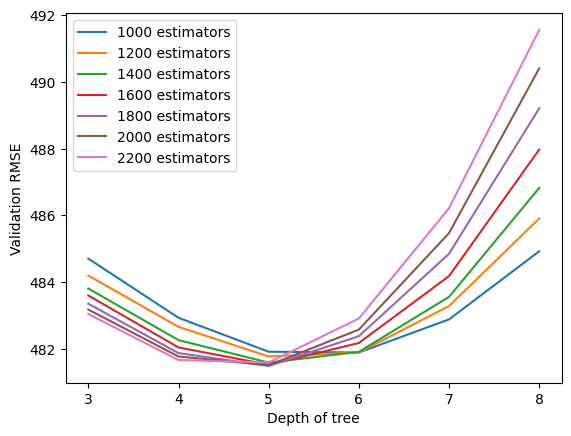

In [21]:
plt.plot(depth, errors[0], label="1000 estimators")
plt.plot(depth, errors[1], label="1200 estimators")
plt.plot(depth, errors[2], label="1400 estimators")
plt.plot(depth, errors[3], label="1600 estimators")
plt.plot(depth, errors[4], label="1800 estimators")
plt.plot(depth, errors[5], label="2000 estimators")
plt.plot(depth, errors[6], label="2200 estimators")

plt.xlabel("Depth of tree")
plt.ylabel("Validation RMSE")
plt.legend()
plt.savefig('figures/xgboost-hyperparam.png', bbox_inches='tight')

### Progress of training

In [39]:
from sklearn.model_selection import KFold
import pandas as pd
from xgboost_utils import preprocess_xgboost

In [47]:
def kfold_xgboost(enc='target'):
    training_data_raw = pd.read_csv('train.csv')
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)

    scores = []
    i = 0

    for train_index, val_index in kfold.split(training_data_raw):
        X_train, X_val = training_data_raw.iloc[train_index], training_data_raw.iloc[val_index]

        X_train = preprocess_xgboost(X_train, encoder=enc)
        X_train, y_train = X_train.drop('monthly_rent', axis=1), X_train[['monthly_rent']]
        X_val = preprocess_xgboost(X_val, True, enc)
        X_val, y_val = X_val.drop('monthly_rent', axis=1), X_val[['monthly_rent']]

        # depth = range(3, 9)
        # errors = []
        # for d in depth:
        
        xgb_model = xgb.XGBRegressor(
                n_estimators=1800, max_depth=5, eta=0.01, subsample=0.7, colsample_bytree=0.7,
                objective="reg:squarederror"
            )
    
        xgb_model.fit(X_train, y_train)
        y_val_pred = xgb_model.predict(X_val)
        error = np.sqrt(mean_squared_error(y_val, y_val_pred))
        # errors.append(error)
        print(d, ":", error)
        
        i += 1
        scores.append(error)

    # def display_scores(scores):
    # print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))
    return scores

In [48]:
scores = kfold_xgboost()

/Users/biqing/Documents/2023-fall/cs5228/project/cs5228_project_commit/xgboost_utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data_raw[col_name] = count_aux_within_radius
/Users/biqing/Documents/2023-fall/cs5228/project/cs5228_project_commit/xgboost_utils.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data_raw[col_name] = aux_distances
/Users/biqing/Documents/2023-fall/cs5228/project/cs5228_project_commit/xgboost_utils.py:60: SettingWithCopyWarning: 
A value is trying to 

8 : 472.54645242178646


/Users/biqing/Documents/2023-fall/cs5228/project/cs5228_project_commit/xgboost_utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data_raw[col_name] = count_aux_within_radius
/Users/biqing/Documents/2023-fall/cs5228/project/cs5228_project_commit/xgboost_utils.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data_raw[col_name] = aux_distances
/Users/biqing/Documents/2023-fall/cs5228/project/cs5228_project_commit/xgboost_utils.py:60: SettingWithCopyWarning: 
A value is trying to 

8 : 489.26631158155595


/Users/biqing/Documents/2023-fall/cs5228/project/cs5228_project_commit/xgboost_utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data_raw[col_name] = count_aux_within_radius
/Users/biqing/Documents/2023-fall/cs5228/project/cs5228_project_commit/xgboost_utils.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data_raw[col_name] = aux_distances
/Users/biqing/Documents/2023-fall/cs5228/project/cs5228_project_commit/xgboost_utils.py:60: SettingWithCopyWarning: 
A value is trying to 

8 : 489.39966656967033


/Users/biqing/Documents/2023-fall/cs5228/project/cs5228_project_commit/xgboost_utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data_raw[col_name] = count_aux_within_radius
/Users/biqing/Documents/2023-fall/cs5228/project/cs5228_project_commit/xgboost_utils.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data_raw[col_name] = aux_distances
/Users/biqing/Documents/2023-fall/cs5228/project/cs5228_project_commit/xgboost_utils.py:60: SettingWithCopyWarning: 
A value is trying to 

8 : 480.27854377851986


/Users/biqing/Documents/2023-fall/cs5228/project/cs5228_project_commit/xgboost_utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data_raw[col_name] = count_aux_within_radius
/Users/biqing/Documents/2023-fall/cs5228/project/cs5228_project_commit/xgboost_utils.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data_raw[col_name] = aux_distances
/Users/biqing/Documents/2023-fall/cs5228/project/cs5228_project_commit/xgboost_utils.py:60: SettingWithCopyWarning: 
A value is trying to 

8 : 481.3439959083697


/Users/biqing/Documents/2023-fall/cs5228/project/cs5228_project_commit/xgboost_utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data_raw[col_name] = count_aux_within_radius
/Users/biqing/Documents/2023-fall/cs5228/project/cs5228_project_commit/xgboost_utils.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data_raw[col_name] = aux_distances
/Users/biqing/Documents/2023-fall/cs5228/project/cs5228_project_commit/xgboost_utils.py:60: SettingWithCopyWarning: 
A value is trying to 

8 : 476.6714879007348


/Users/biqing/Documents/2023-fall/cs5228/project/cs5228_project_commit/xgboost_utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data_raw[col_name] = count_aux_within_radius
/Users/biqing/Documents/2023-fall/cs5228/project/cs5228_project_commit/xgboost_utils.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data_raw[col_name] = aux_distances
/Users/biqing/Documents/2023-fall/cs5228/project/cs5228_project_commit/xgboost_utils.py:60: SettingWithCopyWarning: 
A value is trying to 

8 : 483.57077881779713


/Users/biqing/Documents/2023-fall/cs5228/project/cs5228_project_commit/xgboost_utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data_raw[col_name] = count_aux_within_radius
/Users/biqing/Documents/2023-fall/cs5228/project/cs5228_project_commit/xgboost_utils.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data_raw[col_name] = aux_distances
/Users/biqing/Documents/2023-fall/cs5228/project/cs5228_project_commit/xgboost_utils.py:60: SettingWithCopyWarning: 
A value is trying to 

8 : 487.84295118884927


/Users/biqing/Documents/2023-fall/cs5228/project/cs5228_project_commit/xgboost_utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data_raw[col_name] = count_aux_within_radius
/Users/biqing/Documents/2023-fall/cs5228/project/cs5228_project_commit/xgboost_utils.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data_raw[col_name] = aux_distances
/Users/biqing/Documents/2023-fall/cs5228/project/cs5228_project_commit/xgboost_utils.py:60: SettingWithCopyWarning: 
A value is trying to 

8 : 475.77179452488633


/Users/biqing/Documents/2023-fall/cs5228/project/cs5228_project_commit/xgboost_utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data_raw[col_name] = count_aux_within_radius
/Users/biqing/Documents/2023-fall/cs5228/project/cs5228_project_commit/xgboost_utils.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data_raw[col_name] = aux_distances
/Users/biqing/Documents/2023-fall/cs5228/project/cs5228_project_commit/xgboost_utils.py:60: SettingWithCopyWarning: 
A value is trying to 

8 : 485.16404753545896


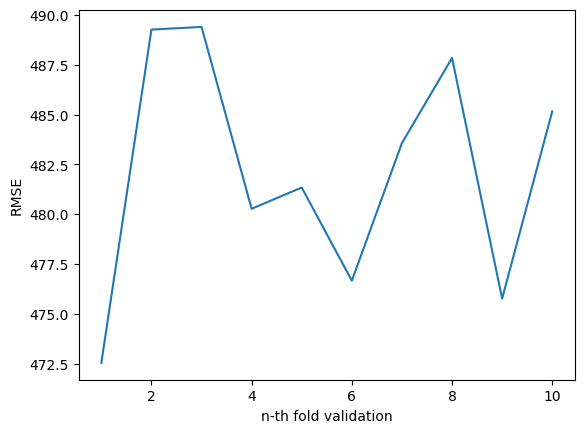

In [51]:
# for i, item in enumerate(scores):
plt.plot(range(1, 11), scores)
    # plt.plot(depth, errors[1], label="1200 estimators")
    # plt.plot(depth, errors[2], label="1400 estimators")
    # plt.plot(depth, errors[3], label="1600 estimators")
    # plt.plot(depth, errors[4], label="1800 estimators")
    # plt.plot(depth, errors[5], label="2000 estimators")
    # plt.plot(depth, errors[6], label="2200 estimators")

plt.xlabel("n-th fold validation")
plt.ylabel("RMSE")
# plt.legend()
plt.savefig('figures/ten-fold-validation.png', bbox_inches='tight')

In [55]:
print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))
print(np.min(scores))
print(np.max(scores))

Scores: [472.54645242178646, 489.26631158155595, 489.39966656967033, 480.27854377851986, 481.3439959083697, 476.6714879007348, 483.57077881779713, 487.84295118884927, 475.77179452488633, 485.16404753545896]
Mean: 482.186
Std: 5.602
472.54645242178646
489.39966656967033
